In [1]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
# or
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Step-1: Loading Dataset

## Dataset Link: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [2]:
heart_df = pd.read_csv('heart.csv')
heart_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


----------

# Step-2: Preprocessing Dataset

In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
heart_df.shape

(918, 12)

In [6]:
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summary_output = pd.DataFrame(df.dtypes, columns=['data type'])
    summary_output['# of missing'] = df.isnull().sum().values 
    summary_output['% of missing'] = df.isnull().sum().values / len(df) * 100
    summary_output['# of unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary_output['min'] = desc['min'].values
    summary_output['max'] = desc['max'].values
    summary_output['average'] = desc['mean'].values
    summary_output['standard deviation'] = desc['std'].values
    
    return summary_output

In [7]:
summary(heart_df)

data shape: (918, 12)


,data type,# of missing,% of missing,# of unique,min,max,average,standard deviation
Age,int64,0,0.00,50,28.00,77.00,53.51,9.43
Sex,object,0,0.00,2,NaN,NaN,NaN,NaN
ChestPainType,object,0,0.00,4,NaN,NaN,NaN,NaN
RestingBP,int64,0,0.00,67,0.00,200.00,132.40,18.51
Cholesterol,int64,0,0.00,222,0.00,603.00,198.80,109.38
FastingBS,int64,0,0.00,2,0.00,1.00,0.23,0.42
RestingECG,object,0,0.00,3,NaN,NaN,NaN,NaN
MaxHR,int64,0,0.00,119,60.00,202.00,136.81,25.46
ExerciseAngina,object,0,0.00,2,NaN,NaN,NaN,NaN
Oldpeak,float64,0,0.00,53,-2.60,6.20,0.89,1.07


## Conclusion: 
- No null values for each column
- Some columns contains relatively many unique values - Cholesterol, MaxHR
- Max value of cholesterol -> 603 , probably is a outlier
- Min value of restingBP and cholesterol are zeros (which is impossible so will check on them later)

## In order to deep dive more, we would like to plot the distribution of each column.

In [8]:
heart_df[heart_df['RestingBP']==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.50,Flat,1


In [9]:
heart_df[heart_df['Cholesterol']==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.00,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.70,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.50,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.70,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.40,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.50,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.00,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.00,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.00,Flat,1


## Since there are scientific researches showing that cholesterol is positively correlated with heart disease, we can use any of the 3 approaches to deal with 172 rows having cholesterol=0.

1. Drop 0 values from the dataset
2. Replace 0 values with mean
3. Replace 0 value with median

In [10]:
# calculate the correlation with the original dataset and the three approaches
org_corr =  round(heart_df['Cholesterol'].corr(heart_df['HeartDisease']),3)
drop_corr = round(heart_df['Cholesterol'].replace(0, np.nan).dropna().corr(heart_df['HeartDisease']),3)
mean_corr = round(heart_df['Cholesterol'].replace(0, np.nan).fillna(heart_df['Cholesterol'].mean()).corr(heart_df['HeartDisease']),3)
median_corr = round(heart_df['Cholesterol'].replace(0, np.nan).fillna(heart_df['Cholesterol'].median()).corr(heart_df['HeartDisease']),3)

In [11]:
check_corr = dict()
check_corr['org_corr'] = org_corr
check_corr['drop_corr'] = drop_corr
check_corr['mean_corr'] = mean_corr
check_corr['median_corr'] = median_corr

check_corr

{'org_corr': -0.233,
 'drop_corr': 0.104,
 'mean_corr': -0.012,
 'median_corr': 0.043}

## Conclusion: We will drop the rows with 0 values.

In [12]:
# drop all rows with 0 values 
# replace the row with restingBP = 0 with the median
heart_df['RestingBP'].replace(0, np.nan).fillna(heart_df['RestingBP'].median())
heart_df['Cholesterol'].replace(0, np.nan, inplace=True)
heart_df.dropna(inplace=True)

In [13]:
# split dataset into train and test set 
features = heart_df.columns[:-1]
target = heart_df.columns[-1]

dataset = heart_df
X = dataset[features]
y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=100)

In [14]:
# identify numerical variables & categorical variables
def num_col_list(df):
    num_col = df.select_dtypes(include=np.number) # or include=['float64','int64']
    num_col_list = num_col.columns.tolist()
    return num_col_list

def cat_col_list(df):
    cat_col = df.select_dtypes(exclude=np.number) # or include=['object']
    cat_col_list = cat_col.columns.tolist()
    return cat_col_list

In [15]:
# feature scaling for numerical features
def standard_scaler(df_train, df_test, numerical_features):
    scaler=StandardScaler()
    df_train = pd.DataFrame(scaler.fit_transform(df_train[numerical_features]), columns=numerical_features)
    df_test = pd.DataFrame(scaler.transform(df_test[numerical_features]), columns=numerical_features)
    return df_train, df_test

def minmax_scaler(df_train, df_test, numerical_features):
    scaler=MinMaxScaler(feature_range=(1, 5))
    df_train = pd.DataFrame(scaler.fit_transform(df_train[numerical_features]), columns=numerical_features)
    df_test = pd.DataFrame(scaler.transform(df_test[numerical_features]), columns=numerical_features)
    return df_train, df_test

We'll prefer Standard Scaler here to follow a normal distribution. Minmax Scaler is neglected since the upper and lower boundaries for features can fluctaute for heart diseases.

In [16]:
X_train_num, X_test_num = standard_scaler(X_train, X_test, num_col_list(X_train))

In [17]:
# one hot encoding for categorical features
def encoding_cat(df_train, df_test, categorical_features):
    encoder = OneHotEncoder(sparse=False, drop='first')
    col_headers = []
    for col in categorical_features:
        col_categories = df_train[col].unique()
        col_header = [col+'_'+category for category in col_categories[1:]]
        col_headers.extend(col_header)
    df_train = pd.DataFrame(encoder.fit_transform(df_train[categorical_features]), columns=col_headers)
    df_test = pd.DataFrame(encoder.transform(df_test[categorical_features]), columns=col_headers)
    return df_train, df_test

In [18]:
X_train_cat, X_test_cat = encoding_cat(X_train, X_test, cat_col_list(X_train))

In [19]:
# combine numerical and categorical features
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [20]:
X_train_final

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,ChestPainType_NAP,ChestPainType_ATA,ChestPainType_TA,RestingECG_LVH,RestingECG_ST,ExerciseAngina_N,ST_Slope_Up,ST_Slope_Down
0,-0.44,-0.28,-0.55,-0.45,-1.81,-0.85,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
1,-0.75,-0.86,-0.99,-0.45,-0.66,-0.85,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2,1.03,1.56,-0.24,2.23,-1.44,0.06,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
3,0.51,-0.28,-0.48,-0.45,-0.37,1.16,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
4,-0.54,0.29,-0.51,-0.45,-1.32,0.52,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,-0.75,0.52,-1.14,-0.45,0.82,0.43,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
592,-1.27,-0.17,0.02,-0.45,0.41,-0.85,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
593,1.14,-0.17,-0.36,-0.45,-0.50,-0.39,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
594,-0.44,-0.17,-0.65,-0.45,1.23,-0.85,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


## Use X_train_final, X_test_final, y_train and y_test for modeling

Trying get_dummies instead of OneHotEncoder

In [21]:
def encoding_cat_2(df_train, df_test, categorical_features):
    df_train=pd.get_dummies(df_train[categorical_features], drop_first=True)
    df_test=pd.get_dummies(df_test[categorical_features], drop_first=True)
    return df_train, df_test

X_train_cat_2, X_test_cat_2 = encoding_cat_2(X_train, X_test, cat_col_list(X_train))

X_train_cat_2.reset_index(drop=True, inplace=True)
X_train_final_2 = pd.concat([X_train_num, X_train_cat_2], axis=1)

X_train_final_2

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-0.44,-0.28,-0.55,-0.45,-1.81,-0.85,True,False,False,False,True,False,True,True,False
1,-0.75,-0.86,-0.99,-0.45,-0.66,-0.85,True,False,False,False,True,False,False,True,False
2,1.03,1.56,-0.24,2.23,-1.44,0.06,True,False,False,False,True,False,True,True,False
3,0.51,-0.28,-0.48,-0.45,-0.37,1.16,True,False,False,False,False,False,True,True,False
4,-0.54,0.29,-0.51,-0.45,-1.32,0.52,False,False,False,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,-0.75,0.52,-1.14,-0.45,0.82,0.43,False,False,True,False,False,False,True,False,False
592,-1.27,-0.17,0.02,-0.45,0.41,-0.85,False,True,False,False,True,False,False,False,True
593,1.14,-0.17,-0.36,-0.45,-0.50,-0.39,True,False,False,False,False,True,False,True,False
594,-0.44,-0.17,-0.65,-0.45,1.23,-0.85,True,False,False,False,True,False,False,True,False


We'll not use get_dummies because it may create problem in training (shape/columns difference in train and test data)

-------------

# Step-3: EDA

In [22]:
# check data imbalance or not
target_values = y.value_counts()
target_values

HeartDisease
0    390
1    356
Name: count, dtype: int64

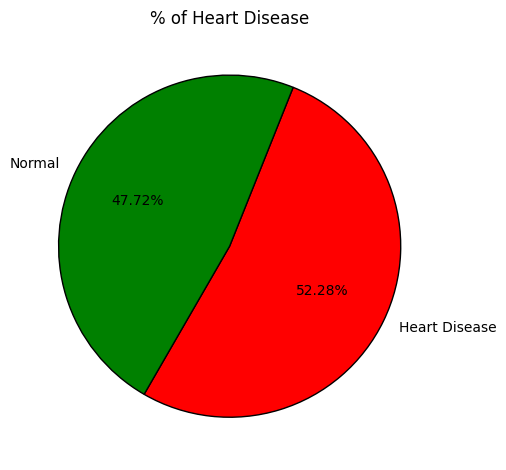

In [23]:
plt.pie(target_values, labels=['Heart Disease', 'Normal'],autopct='%.2f%%',
       startangle=240, colors=['red','green'], wedgeprops={'edgecolor':'k','linewidth':1,'antialiased' : True})
plt.title('% of Heart Disease')
plt.tight_layout()
plt.show()

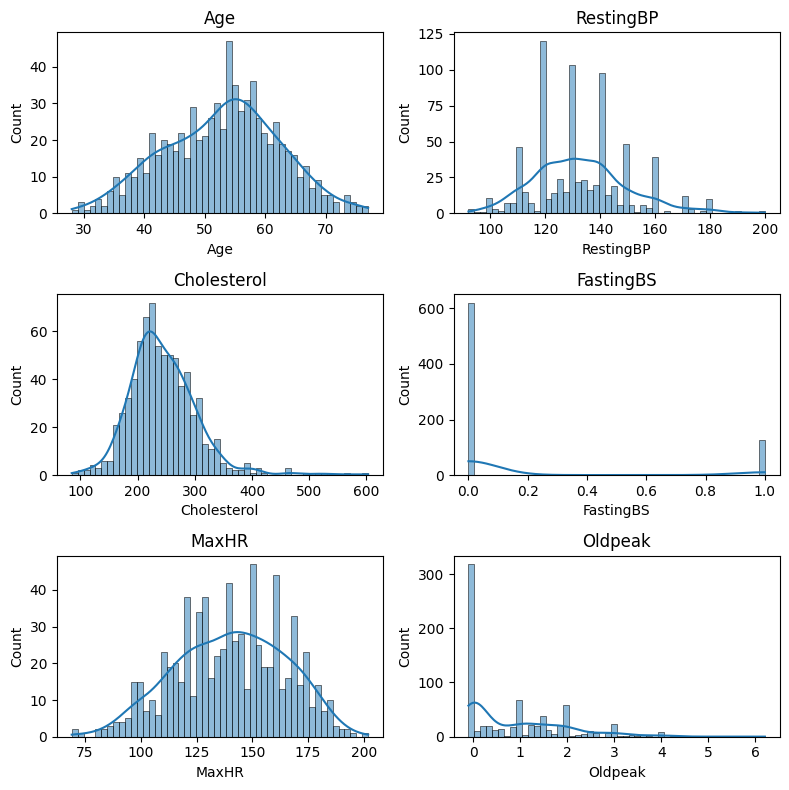

In [24]:
# distribution of numerical variables
numerical_columns = num_col_list(X)

num_cols = 2
num_rows = int(np.ceil(len(numerical_columns)/num_cols))

plt.subplots(num_rows, num_cols, figsize=(8,8))

for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data=X, x=col, bins=50, kde=True)
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()

plt.show()

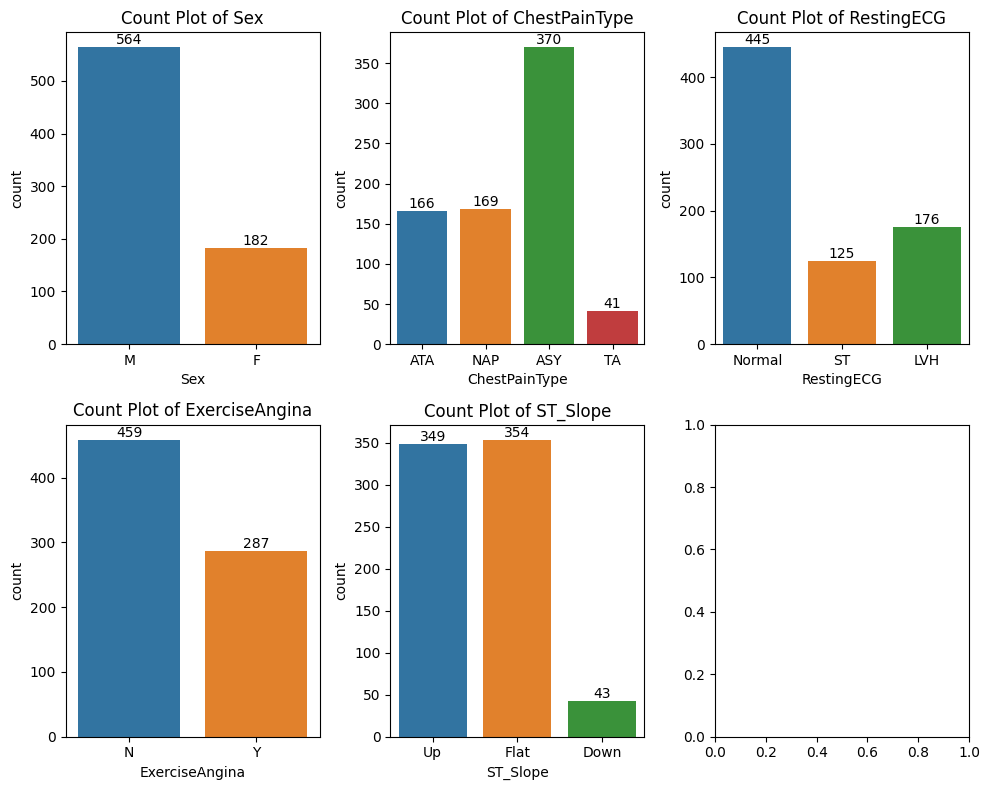

In [25]:
# plot count of categorical variables
categorical_columns = cat_col_list(X)

num_cols = 3
num_rows = int(np.ceil(len(categorical_columns)/num_cols))

plt.subplots(num_rows, num_cols, figsize=(10,8))

for i, col in enumerate(categorical_columns, start=1):
    plt.subplot(num_rows, num_cols, i)
    ax = sns.countplot(data=X, x=col)
    plt.title(f'Count Plot of {col}')
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout() # to adjust layout

plt.show()

<Axes: >

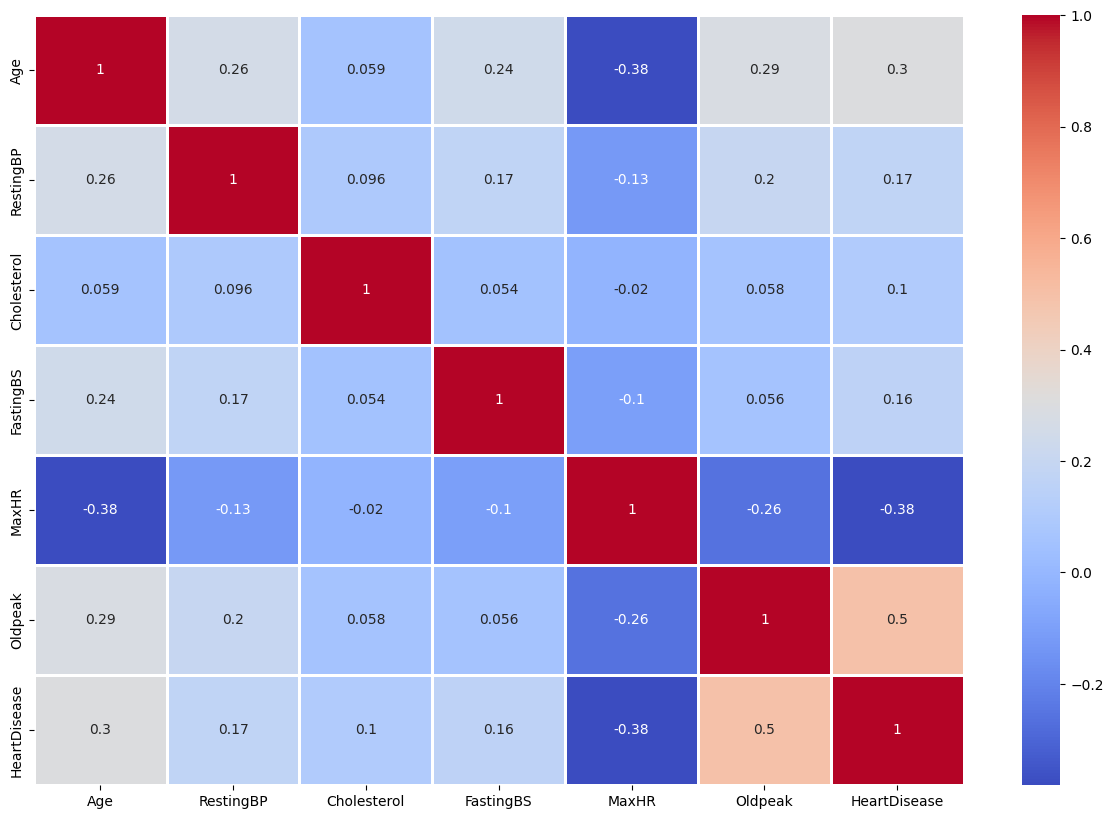

In [26]:
# correlation check for all numerical variables
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

numerical_columns = num_col_list(heart_df)

sns.heatmap(heart_df[numerical_columns].corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

In [27]:
# correlation check for all variables

# function to correlate categorical column with numerical target column (independence and association of attributes concept)
def cramers_v(x, y):
    matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(matrix.shape) - 1)))

def calculate_correlations(df, target_column):
    correlations = {}
    for column in df.columns:
        if df[column].dtype == 'object':  # Categorical column
            correlations[column] = cramers_v(df[column], df[target_column])
        else:  # Numerical column
            correlations[column] = df[[column, target_column]].corr().iloc[0, 1]
    return correlations

correlations = calculate_correlations(heart_df, 'HeartDisease')

# sort the correlations and round off values to 3 digits
correlations = dict(sorted(correlations.items(), key=lambda x: x[1], reverse=True))
correlations = {k: round(v, 3) for k, v in correlations.items()}
correlations

{'HeartDisease': 1.0,
 'ST_Slope': 0.654,
 'ExerciseAngina': 0.549,
 'ChestPainType': 0.537,
 'Oldpeak': 0.496,
 'Age': 0.299,
 'Sex': 0.29,
 'RestingBP': 0.173,
 'FastingBS': 0.161,
 'RestingECG': 0.136,
 'Cholesterol': 0.104,
 'MaxHR': -0.377}

### Highest Correlated Feature - ST_Slope and Lowest Correlated Feature - MaxHR

In [28]:
# Variance Inflation Factors Calculation in the final dataset

X_train_final_vif = add_constant(X_train_final)
vif = pd.DataFrame()
vif["variables"] = X_train_final_vif.columns
vif["VIF"] = [variance_inflation_factor(X_train_final_vif.values, i) for i in range(X_train_final_vif.shape[1])]
vif

,variables,VIF
0,const,28.89
1,Age,1.40
2,RestingBP,1.17
3,Cholesterol,1.06
4,FastingBS,1.14
5,MaxHR,1.49
6,Oldpeak,1.84
7,Sex_F,1.09
8,ChestPainType_NAP,1.58
9,ChestPainType_ATA,1.38


---------------

# Step-4: Fitting and Evaluating Model

## 1. Default Training

In [29]:
# fit the model to the training data
logistic_model = LogisticRegression()
logistic_model.fit(X_train_final, y_train)

# predict using the model
y_pred = logistic_model.predict(X_test_final)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [30]:
# test/ evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:\n", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy:
 0.9
Confusion Matrix:
 [[77  9]
 [ 6 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        86
           1       0.87      0.91      0.89        64

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



In [31]:
y_pred_proba = logistic_model.predict_proba(X_test_final)[:, 1]  # Probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC Score: {auc_score}')

AUC Score: 0.9678415697674418


## 2. Optimized Training using Grid Search CV

In [32]:
# create a logistic regression model
logistic_model = LogisticRegression()

# define a dictionary of hyperparameters and their possible values for tuning
param_grid = {
    'C': [0.1, 0.4, 0.9, 1, 2],  # Regularization parameter
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty type
    'solver': [
                'lbfgs',
                'liblinear',
                'newton-cholesky',
                'newton-cg',
                'sag',
                'saga'
              ],  # Solver algorithm
    'max_iter': [50, 100, 150] # Iterations for convergence
}

# create a GridSearchCV object
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=6, scoring='accuracy', verbose=1)

# fit the GridSearchCV object to the training data
model = grid_search.fit(X_train_final, y_train)

# get the best parameters from the grid search
best_params = model.best_params_
print("Best Parameters for Logistic Regression Model: ", best_params)

# predict using the best model
best_estimator = model.best_estimator_
y_predicted = best_estimator.predict(X_test_final)
y_predicted

Fitting 6 folds for each of 270 candidates, totalling 1620 fits
Best Parameters for Logistic Regression Model:  {'C': 0.9, 'max_iter': 50, 'penalty': 'l1', 'solver': 'saga'}


array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [33]:
# test/ evaluate the model
accuracy = accuracy_score(y_test, y_predicted)
confusion = confusion_matrix(y_test, y_predicted)
classification_rep = classification_report(y_test, y_predicted)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9
Confusion Matrix:
 [[77  9]
 [ 6 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        86
           1       0.87      0.91      0.89        64

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



----------------

# Step-5: Dropping Features

## Case 1: Dropping ST_Slope (Highest Correlated Feature)

In [34]:
X_train_high_cor_drop = X_train_final.drop(columns = ['ST_Slope_Up', 'ST_Slope_Down'])
X_test_high_cor_drop = X_test_final.drop(columns = ['ST_Slope_Up', 'ST_Slope_Down'])

In [35]:
# fit the GridSearchCV object to the training data
model = grid_search.fit(X_train_high_cor_drop, y_train)

# predict using the best model
best_estimator = model.best_estimator_
y_pred = best_estimator.predict(X_test_high_cor_drop)
y_pred

Fitting 6 folds for each of 270 candidates, totalling 1620 fits


array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [36]:
# test/ evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:\n", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy:
 0.8466666666666667
Confusion Matrix:
 [[75 11]
 [12 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87        86
           1       0.83      0.81      0.82        64

    accuracy                           0.85       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.85      0.85      0.85       150



## Case 2: Dropping MaxHR (Lowest Correlated Feature)

In [37]:
X_train_low_cor_drop = X_train_final.drop(columns = ['MaxHR'])
X_test_low_cor_drop = X_test_final.drop(columns = ['MaxHR'])

In [38]:
# fit the GridSearchCV object to the training data
model = grid_search.fit(X_train_low_cor_drop, y_train)

# predict using the best model
best_estimator = model.best_estimator_
y_pred = best_estimator.predict(X_test_low_cor_drop)
y_pred

Fitting 6 folds for each of 270 candidates, totalling 1620 fits


array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [39]:
# test/ evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9
Confusion Matrix:
 [[77  9]
 [ 6 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        86
           1       0.87      0.91      0.89        64

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150

